# N Games Lookback


This notebook hopes to identify how many games of lookback correspond to optimal amount, if at all, one can use to create a proxy for played games. 

In [2]:
#import dependencies and dataset

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

%matplotlib inline

dataset = '../data/NBADATA.csv'

In [3]:
def rolling_correlations(data,ngames):
    """Determines the correlation between a team's performance in a
    particular category compared to that team's split average over the previous ngames. 
    Use this function to determine optimal lookback period. 
    
    data : df
        Dataframe containing all the box scores over previous 5 season. 
        
    ngames : int
        Lookback splits. Ex: ngames=5 corresponds to team's splits over previous 5 games. 
    """
    
    
#delete irrelevant columns (for this section), they will be useful for other pieces of the study but not here!
    nba_explore = pd.read_csv(dataset)
    del nba_explore['Unnamed: 0'],nba_explore['GAME_ID'],nba_explore['Date'],nba_explore['Team'],nba_explore['Home'],nba_explore['Away']
    del nba_explore['OU'],nba_explore['TOTAL']

#add some other potential columns, like efficency. 
    nba_explore['3P%'] = np.divide(nba_explore['3P'].values,nba_explore['3PA'].values) 

    nba_explore['FG%'] = np.divide(nba_explore['FG'].values,nba_explore['FGA'].values)
    nba_explore['FT%'] = np.divide(nba_explore['FT'].values,nba_explore['FTA'].values)
    nba_explore['TRB']  = nba_explore['OR'] + nba_explore['DR']

    nba_explore['AST/TO'] = np.divide(nba_explore['AST'].values,nba_explore['TO'].values)


    relevant_stats = []
    for col in nba_explore.columns:
        if col != 'PLUS_MINUS':
           # print(col + " Correlation to Outcome")
            corr = np.corrcoef(nba_explore[col],nba_explore['PLUS_MINUS'])
            #print(corr[0][1])
            if abs(corr[0][1]) < .1:
                pass
            else:
                relevant_stats.append(col)
        

    print("Using a window of " ,ngames, " games. ")
    data['AST/TO'] = np.divide(data['AST'].values,data['TO'].values)
    data['3P%'] = np.divide(data['3P'].values,data['3PA'].values) 
    data['FG%'] = np.divide(data['FG'].values,data['FGA'].values)
    data['FT%'] = np.divide(data['FT'].values,data['FTA'].values)
    del data['Unnamed: 0'],data['TOTAL']
   # del data['Date']
    data = data.loc[data['GAME_ID'].values < 41300001] #genius! No playoff games now :)   
    #del data['Team'] 
    #data = pd.get_dummies(data) #sometimes option to hot tcode team, but not yet. Seems like overfitting. 
    teams = data.Team.unique() #each nba team. 
#iterate over those teams, make a rolling window
    nba_data = pd.DataFrame([])
    season_ids = []
    for i,val in enumerate(data['GAME_ID'].values):  #loop through every game
        season_ids.append(str(val)[1:3])

    data['Season_ID'] = season_ids #identify the unique seasons. 

    for team in teams:  #for each team
       # print(team)
    #get separate seasons here
        team_data = data.loc[data['Team'] == team]  #this contains the box score of every team game from 2013 to 2018.
        for season in data['Season_ID'].unique(): #this contains the box score of that team for that season. 
            #print(season)
            team_season = team_data.loc[team_data['Season_ID'] == season]
        
            stuff_to_turn_into_avgs =  relevant_stats  #['OR', 'DR', 'TOT', 'PF', 'ST', 'TO', 'BL', '3P%', 'FG%', 'FT%']
            for col in team_season.columns:
                if col in stuff_to_turn_into_avgs:
                        team_season['Rolling ' + col] = team_season[col].rolling(window=ngames).mean().shift(1)

            #split each season up here, 
                    #if col != 'PTS':
                    #    team_season['Rolling ' + col] = team_season[col].rolling(window=N_GAMES).mean().shift(1)

                        del team_season[col]
                    
            nba_data =  nba_data.append(team_season)

           # df = pd.concat([road_df,home_df],axis=1)
#reorganize the dataset. 
    nba_data_splits = nba_data.sort_values(by = ['GAME_ID', 'Home','Away'], ascending=[True, True,False])

    nba_data_splits.dropna(inplace=True)

    del nba_data_splits['Home'], nba_data_splits['Away'], nba_data_splits['FGA'], nba_data_splits['3PA'], nba_data_splits['FTA'], nba_data_splits['OR'],nba_data_splits['PF']                                                                                                                                
    del nba_data_splits['PLUS_MINUS'], nba_data_splits['OU'],nba_data_splits['Rolling SPREAD'],nba_data_splits['Season_ID']
    nba_dataset = pd.read_csv(dataset)                                                                                                               
    rolling_vals = nba_data_splits
  #  print(rolling_vals.head())
    game_vals = nba_dataset
    merged = game_vals.merge(rolling_vals,on=['GAME_ID','Team'])
    print(rolling_vals.columns)
#   del merged['GAME_ID'],merged['Team'],merged['Home'],merged['Away'],merged['SPREAD']
  #  print("do dates align? ")
 #   print(merged[['Date_x','Date_y']].values[0:10])
    total_corr = 0
    for col in merged:
        try:
            corr = np.corrcoef(merged[col],merged['Rolling ' + col])[0][1]
            #print(col)
            #print(corr)
            total_corr += abs(corr)
        except:
            pass
    return total_corr

In [4]:
ngames = [1,3,5,10,15,22,30,40,50,60,75,81]  #various N Game split sizes. 
ngame_corrs = []
for lookback in ngames:
    nba_dataset = pd.read_csv('../data/NBADATA.csv')
    total_corr = rolling_correlations(nba_dataset,lookback)
    print("Total Correlation = ", total_corr)
    ngame_corrs.append(total_corr)
  

Using a window of  1  games. 


/Users/noahkasmanoff/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/noahkasmanoff/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Index(['GAME_ID', 'Date', 'Team', 'Rolling FG', 'Rolling 3P', 'Rolling FT',
       'Rolling DR', 'Rolling AST', 'Rolling ST', 'Rolling TO', 'Rolling BL',
       'Rolling PTS', 'Rolling AST/TO', 'Rolling 3P%', 'Rolling FG%',
       'Rolling FT%'],
      dtype='object')
Total Correlation =  1.32682989651
Using a window of  3  games. 
Index(['GAME_ID', 'Date', 'Team', 'Rolling FG', 'Rolling 3P', 'Rolling FT',
       'Rolling DR', 'Rolling AST', 'Rolling ST', 'Rolling TO', 'Rolling BL',
       'Rolling PTS', 'Rolling AST/TO', 'Rolling 3P%', 'Rolling FG%',
       'Rolling FT%'],
      dtype='object')
Total Correlation =  1.91354567747
Using a window of  5  games. 
Index(['GAME_ID', 'Date', 'Team', 'Rolling FG', 'Rolling 3P', 'Rolling FT',
       'Rolling DR', 'Rolling AST', 'Rolling ST', 'Rolling TO', 'Rolling BL',
       'Rolling PTS', 'Rolling AST/TO', 'Rolling 3P%', 'Rolling FG%',
       'Rolling FT%'],
      dtype='object')
Total Correlation =  2.14684256513
Using a window of  10  games

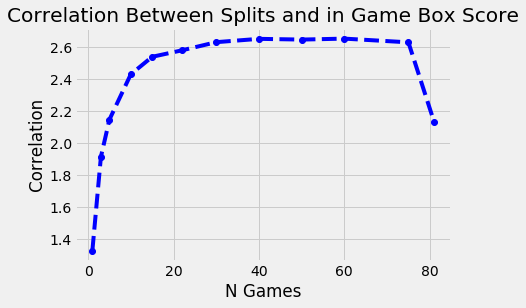

In [5]:
plt.style.use('fivethirtyeight')
  
plt.title('Correlation Between Splits and in Game Box Score')   
plt.xlabel('N Games')
plt.ylabel('Correlation')
plt.plot(ngames,ngame_corrs,'bo--')

# Now after seeing this line of diminishing returns, it appears that ~30 games is the optimal average to use for correlating between a team's upcoming game and it's performance in the previous N games. In order to now translate this into a dataset ready for a machine learning model, please head over to the "Create ML Dataset" notebook also located in this repo. 